In [13]:
# !pip install hypernetx

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import hypernetx as hnx

# Data

The data in several of our notebooks are taken from the jean.dat dataset available from the Stanford GraphBase at https://www-cs-faculty.stanford.edu/~knuth/sgb.html. This data gives character scene incidence information from the novel **Les Miserables** by Victor Hugo.


In [3]:
scenes = {
    0: ('FN', 'TH'),
    1: ('TH', 'JV'),
    2: ('BM', 'FN', 'JA'),
    3: ('JV', 'JU', 'CH', 'BM'),
    4: ('JU', 'CH', 'BR', 'CN', 'CC', 'JV', 'BM'),
    5: ('TH', 'GP'),
    6: ('GP', 'MP'),
    7: ('MA', 'GP')
}

H = hnx.Hypergraph(scenes)

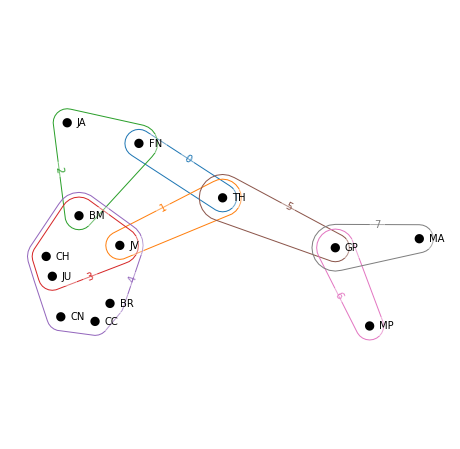

In [4]:
# Draw the hypergraph! For more on using all of the parameters
# of the draw function see the Visualization tutorial
hnx.draw(H)

HNX hypergraphs can also be built from networkx bipartite graph objects using `from_bipartite`

In [5]:
B = nx.Graph()
B.add_nodes_from([1, 2, 3, 4], bipartite=0)
B.add_nodes_from(['a', 'b', 'c'], bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from([(1, 'a'), (1, 'b'),(2, 'a'), (2, 'b'), (2, 'c'), (3, 'c'), (4, 'a')])

HB = hnx.Hypergraph.from_bipartite(B)


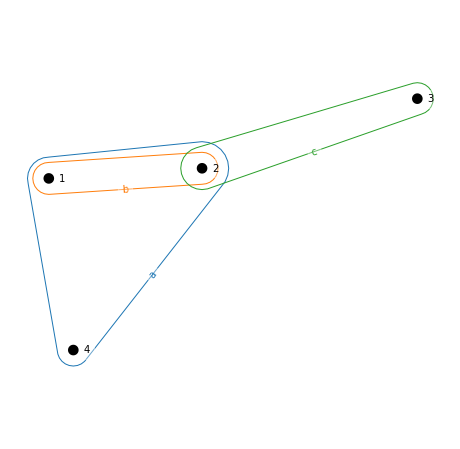

In [6]:
hnx.draw(HB)

All hypergraphs have a natural dual structure where the edges and nodes switch roles. Edges become nodes and nodes become edges. This can be constructed by callig the `dual` method for a given hypergraph.

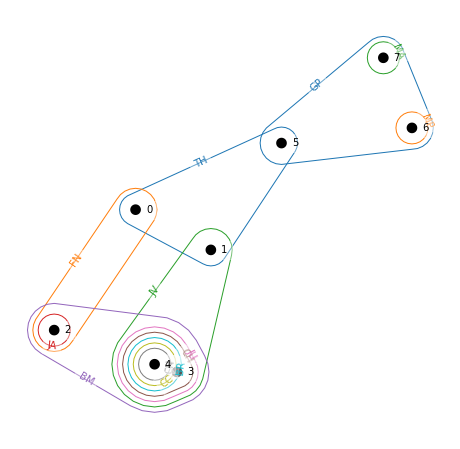

In [7]:
HD = H.dual()
hnx.draw(HD)

There are many simple methods to begin to familiarize yourself with the hypergraph.

In [8]:
# See the nodes as Entities within an EntitySet object

H.nodes

EntitySet(:Nodes,['CN', 'TH', 'CC', 'GP', 'BM', 'FN', 'MP', 'JA', 'JU', 'JV', 'BR', 'CH', 'MA'],{'weight': 1.0})

In [9]:
# Use list() to get just the names of the nodes

list(H.nodes)

['FN', 'TH', 'JV', 'BM', 'JA', 'JU', 'CH', 'BR', 'CN', 'CC', 'GP', 'MP', 'MA']

In [10]:
# Similarly for edges

H.edges

EntitySet(:Edges,[0, 1, 2, 3, 4, 5, 6, 7],{'weight': 1.0})

In [11]:
list(H.edges)

[0, 1, 2, 3, 4, 5, 6, 7]

In [12]:
# The number of nodes and edges is returned by the shape property

H.shape

(13, 8)

The degree of a node is the number of edges it is contained within. The (optional) `s` parameter places a restriction on the size of the edges you consider. The degree function looks for all edges of size $\geq s$. The (optional, not shown here) edges parameter allows you to restrict to a specific edge set.

Note: `H.s_degree(node)` is a wrapper for the degree method and returns the same thing.

In [ ]:
H.degree('JV', s=1)

The dim (dimension) and size methods return information about an edge. The size is the number of nodes contained in an edge and the dimension is one less than the size. The dimension is so named because if we consider a hypergraph as a simplicial complex then each edge is a simplex. The dimension of a simplex is one less than its number of nodes.

In [ ]:
H.dim(3), H.size(3)

The neighbors method returns an interator that goes through all nodes which share an edge with the given node.

In [ ]:
for nei in H.neighbors('JV'):
    print(nei)
    
# As with any iterator you can get all of the values in a list
list(H.neighbors('JV'))

# Hypergraph representations
There are different ways representing the data contained within the hypergraph. `H.incidence_dict` returns a dictionary whereas `H.incidence_matrix()` returns a scipy sparse matrix in Compressed Sparse Row format. `H.bipartite()` returns a networkx bipartite `Graph()` object.

In [ ]:
H.incidence_dict

In [ ]:
M_incidence = H.incidence_matrix()
M_incidence.toarray()

In [ ]:
## Networkx and HyperNetX visualizations of the bipartite representation of the hypergraph
fig,ax = plt.subplots(1,2,figsize=(15,8))
BH = H.bipartite()
top = nx.bipartite.sets(BH)[0]
pos = nx.bipartite_layout(BH, top)
nx.draw(BH, with_labels=True,pos=pos,ax=ax[0])
hnx.drawing.two_column.draw(H,ax=ax[1])

# Connected components
Just as is done in graphs we can consider connected components of a hypergraph. But because edges can intersect in any number of nodes the connected components can be computed for different levels of connection strength. HNX has two main methods for exploring the components: `s_components` and `s_component_subgraphs`. To learn more about some of our research in this area check out our paper 
<a href="https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-020-00231-0">
Hypernetwork science via high order hypergraph walks</a>.

`s_components` returns a generator object which iterates through the edge sets for each s-connected component.  

In [ ]:
print('1-component edge sets:')
for comp in H.s_components(s=1):
    print(comp)

print('\n2-component edge sets:')
for comp in H.s_components(s=2):
    print(comp)
    

`s_component_subgraphs` returns a generator object which iterates through the sub-hypergraph for each s-connected component.  

In [ ]:
print('1-component sub-hypergraph incidence dictionaries:')
for comp in H.s_component_subgraphs(s=1):
    print(comp.incidence_dict)

print('\n2-component sub-hypergraph incidence dictionaries:')
for comp in H.s_component_subgraphs(s=2):
    print(comp.incidence_dict)
    

The methods `component_subgraphs` and `connected_component_subgraphs` are wrappers for `s_component_subgraphs`, and the methods `components` and `connected_components` are wrappers for `s_components`.  

The `is_connected` method with optional parameter `s` (default `s=1`) returns `True` or `False` depending on whether the hypergraph is s-connected.

In [ ]:
# The Les Mis example hypergraph is 1-connected but not 2-connected

H.is_connected(s=1), H.is_connected(s=2)

# Adjacency matrices
In order to compute s-connected components we use a helper auxiliary matrix: the s-adjacency matrix of the edges of size >= s. Two edges are considered s-adjacent if they intersect in at least s nodes. This is computed using `auxillary_matrix`. The output is a scipy compressed sparse row matrix.

**Note**: At present these matrices are unweighted, we will introduce weighting in a near future release.

In [ ]:
M_aux1 = H.auxiliary_matrix(s=1)
M_aux1.toarray()

In [ ]:
M_aux3 = H.auxiliary_matrix(s=3)
M_aux3.toarray()

There are two helper functions: `adjacency_matrix` and `edge_adjacency_matrix`. The former is the s-adjacency matrix of all nodes where two nodes are considered s-adjacent if they are in s edges together. The latter is the same as the auxiliary matrix but for all edges (not just those of size >= s). 

# Distances and diameters
Just as connected components of graphs generalized to s-connected components in hypergraphs, the distance and diameter can be generalized to s-distance and s-diameter in hypergraphs. 

We can compute s-distance between edges using `edge_distance` and between nodes using `distance`. See the glossary in the documentation for detailed definitions of distance between edges and between nodes.

In [ ]:
# Optional parameter s is not shown, defaults to s=1

H.distance('MA', 'FN')

In [ ]:
# Optional parameter s is not shown, defaults to s=1

H.edge_distance(4, 6)

If the edges or nodes are not $s$-connected then the $s$-distance displays a warning and returns `inf`.

In [ ]:
H.edge_distance(4, 6, s=2)

The $s$-diameter (`diameter`) is the longest distance between any two nodes and the $s$-edge diameter (`edge_diameter`) is the longest distance between any two edges.

In [ ]:
# Optional parameter s is not shown, default is s=1

H.diameter(), H.edge_diameter()

If the hypergraph is not $s$-connected then the diameter methods throw a `HyperNetXError`.

In [ ]:
# ## Uncomment this cell to test the error message
# H.diameter(s=2)

If your hypergraph is not s-connected but you want to explore the s-diameters of all of the s-connected components (edge or node) use `node_diameters` and `edge_diameters`. This returns a tuple where the first element is the maximum diameter over all s-components, the second element is the list of all s-diameters, and the third is the list of the s-components (edges or nodes).

In [ ]:
H.node_diameters(s=2)

In [ ]:
H.edge_diameters(s=2)

# Collapsing nodes and edges
Sometimes a set of nodes are in the exact same set of edges, or more than one edge encloses the exact same set of nodes. We call these duplicate nodes and duplicate edges. They can be collapsed to a single representative using `collapse_nodes`, `collapse_edges`, and `collapse_nodes_and_edges`.

There are some parameters that can be used:
* use_reps = True/False : default is False and each "supernode" is represented by a frozenset of the nodes which it represents. If use_reps=True then a single representative will be chosen from those sets.
* return_counts = True/False : default is True and it keeps the counts of the nodes within each supernode. However, this only works when use_reps=True because if use_reps=False then the counts are just the sizes of the frozensets.

Keeping the default parameters and running the function with no arguments works best with the draw method.

In [ ]:
H_node_collapse = H.collapse_nodes()
H_node_collapse.incidence_dict

Running the draw function on a collapsed hypergraph will show the supernodes as larger, depending on how many nodes each represents.

In [ ]:
hnx.draw(H_node_collapse)

In [ ]:
# There are no duplicate edges in H, but there are in the dual of H

HD_edge_collapse = HD.collapse_edges()

In [ ]:
hnx.draw(HD_edge_collapse, with_edge_counts=True)

`collapse_nodes_and_edges` simply runs both of the above collapsing commands.

# Updating the Hypergraph
You can add edges to and remove edges from an an existing hypergraph.

In [ ]:
edge1 = hnx.Entity('new1', elements=['JV', 'MA'])
edge2 = hnx.Entity('new2', elements=['GP', 'MA'])
edge3 = hnx.Entity('new3', elements=['FN', 'JV'])

# add a single edge
H.add_edge(edge1)

# add edges from a list of edges
H.add_edges_from([edge2, edge3])

# display the incidence dictionary with new edges now added
H.incidence_dict

In [ ]:
hnx.draw(H)

In [ ]:
H.remove_edge('new3')
H.remove_edges(['new1', 'new2'])
H.incidence_dict

In [ ]:
hnx.draw(H)

You can also add nodes to already existing edges.

In [ ]:
H.add_node_to_edge('SantaClaus', 7)
H.incidence_dict

In [ ]:
hnx.draw(H)

In [ ]:
H.remove_node('SantaClaus')

In [ ]:
hnx.draw(H)

# Building sub-hypergraphs
There are two methods to look at different kinds of sub-hypergraphs formed from specific sets of nodes (and all edges that they are included in) or sets of edges (and all nodes contained in the edges): `restrict_to_nodes` and `restrict_to_edges`.

In [ ]:
H_restrict_nodes = H.restrict_to_nodes(['JA', 'FN', 'JV', 'MA', 'BM', 'TH'])
hnx.draw(H_restrict_nodes)

Notice that edges in these subgraphs restricted to nodes may be smaller than the edges in the original hypergraph. For example, in `H` edge 3 contains BM, CH, JU, and JV but in this sub-hypergraph it only contains BM and JV because CH and JU were not in our node set.

In [ ]:
H_restrict_nodes.incidence_dict

In [ ]:
H_restrict_edges = H.restrict_to_edges([0, 1, 2, 3])
hnx.draw(H_restrict_edges)

Another way to get a sub-hypergraph is to remove "uninteresting" components. This may be different depending on what you are using as your data set to build a hypergraph. But one simple and almost universally uninteresting component is an "isolated singleton". These are edges of size 1 which are not duplicated. They can be removed from a hypergraph using `remove_singletons`.

In [ ]:
H_restrict_nodes_no_singletons = H_restrict_nodes.remove_singletons()
hnx.draw(H_restrict_nodes_no_singletons)

If the isolated singletons are actually interesting to you then you can use the `singletons` method to find them. This returns a list of isolated singleton edges.

In [ ]:
H_restrict_nodes.singletons()

Finally, sometimes we care only about top level hyperedges, those which are not contained in any other hyperedge (though they may intersect others). We call these toplexes and they can be found using the `toplexes` method. This returns a new hypergraph consisting only of the toplex hyperedges.

In [ ]:
# The only non-toplex in our Les Mis example is edge 3

H_top = H.toplexes()
hnx.draw(H_top)